In [9]:
# general:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV       # hyperparam selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef  # matric for performance evaluation in training
# self-writtten:
import data_cleaner as dc  # self-writtten data cleaning functions
import ML_func as ml       # self-written ML related functions
pd.set_option('display.max_rows', 500)  # let pd.df display() 500 rows
pd.set_option('display.max_columns', 500)

In [10]:
x_train = pd.read_csv("../clean_data/impute/train1.csv")   # use imputed data
x_test = pd.read_csv("../clean_data/mci_wv23_imp.csv")   
y_train = x_train.pop("progress")
y_test = x_test.pop("progress")
x_train, train_imp_mean_sd = dc.standardization(x_train)
x_test, test_imp_mean_sd = dc.standardization(x_test)

In [9]:
cat_cols = x_train.apply(lambda x : (x.dtype=="int64") and (len(x.unique())<10) )
cat_cols = x_train.columns[cat_cols].to_list()




In [12]:
#mod_cat = cat.CatBoostClassifier(cat_features=cat_cols)
#mod_cat.fit(x_train, y_train)
mod_cat.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'Logloss',
 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1'],
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'fold_permutation_block': 0,
 'leaf_estimation_method': 'Newton',
 'counter_calc_method': 'SkipTest',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'ctr_leaf_count_limit': 18446744073709551615,
 'bayesian_matrix_reg': 0.10000000149011612,
 'one_hot_max_size': 2,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': False,
 'max_ctr_complexity': 4,
 'model_size_reg': 0.5,
 'simple_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=Min

In [15]:
import catboost as cat
params = {
    'depth':[3,6,9],           # key to ctrl overfit
    'learning_rate':[0.005, 0.009, 0.02, 0.05],       # default: 0.009
    'l2_leaf_reg':[0,1.5,3]   # L2 regularization
    
}
mod_cat = cat.CatBoostClassifier(cat_features=cat_cols, random_seed=0, verbose=100)
cv_cat = GridSearchCV(
    estimator = mod_cat, 
    param_grid=params,
    cv=10,
    scoring = 'matthews_corrcoef'  # because outcome imbalanced
)
cv_cat.fit(x_train, y_train)       
pd.DataFrame(cv_cat.cv_results_).sort_values("rank_test_score").head() 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_depth,param_l2_leaf_reg,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
10,1.758793,0.061690,0.002926,0.000609,3,3,0.02,"{'depth': 3, 'l2_leaf_reg': 3, 'learning_rate'...",0.264478,0.338487,0.184474,0.095254,0.381227,0.272254,0.484165,0.643449,0.513353,0.533417,0.371056,0.163330,1
7,1.923670,0.086386,0.003322,0.000925,3,1.5,0.05,"{'depth': 3, 'l2_leaf_reg': 1.5, 'learning_rat...",0.160036,0.442105,0.131250,0.124642,0.406566,0.437167,0.437167,0.643449,0.457490,0.460277,0.370015,0.163531,2
5,1.823649,0.090547,0.002703,0.000317,3,1.5,0.009,"{'depth': 3, 'l2_leaf_reg': 1.5, 'learning_rat...",0.266029,0.372871,0.234868,0.160036,0.319756,0.358891,0.272254,0.583114,0.513353,0.525443,0.360662,0.132145,3
6,1.856636,0.094037,0.003259,0.000708,3,1.5,0.02,"{'depth': 3, 'l2_leaf_reg': 1.5, 'learning_rat...",0.216338,0.407553,0.280554,0.069985,0.465818,0.233618,0.484165,0.517815,0.457490,0.440101,0.357344,0.140236,4
0,1.779638,0.073667,0.003075,0.000577,3,0,0.005,"{'depth': 3, 'l2_leaf_reg': 0, 'learning_rate'...",0.253868,0.458508,0.298199,0.204833,0.219096,0.281347,0.272254,0.517815,0.441637,0.525443,0.347300,0.118293,5


In [19]:
cat_params = cv_cat.best_params_
max_iterator = 2000  # default 1000
best_it = []
for i in range(5):
    cat_train, cat_validate, o_train, o_validate = train_test_split(
        x_train, y_train, train_size=0.8, stratify=y_train, random_state = i*10)
    mod_cat = cat.CatBoostClassifier(cat_features=cat_cols, random_seed=i,
                           verbose=200, iterations=max_iterator,
                           early_stopping_rounds = max_iterator//10,
                           **cat_params
                          )
    mod_cat.fit(cat_train, o_train,
                eval_set=[(cat_train, o_train), (cat_validate, o_validate)]) 
    best_it.append(mod_cat.best_iteration_)
print(f"Best iteration for each round: {best_it}; mean={sum(best_it)/5}")
cat_it = round(sum(best_it)/5)


0:	learn: 0.6795210	test: 0.6795210	test1: 0.6801166	best: 0.6801166 (0)	total: 3.33ms	remaining: 6.66s
200:	learn: 0.2588090	test: 0.2597984	test1: 0.3602131	best: 0.3602131 (200)	total: 324ms	remaining: 2.9s
400:	learn: 0.1994579	test: 0.2020542	test1: 0.3547685	best: 0.3524002 (385)	total: 726ms	remaining: 2.89s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3524001663
bestIteration = 385

Shrink model to first 386 iterations.
0:	learn: 0.6812385	test: 0.6812385	test1: 0.6804949	best: 0.6804949 (0)	total: 1.45ms	remaining: 2.91s
200:	learn: 0.2660766	test: 0.2665310	test1: 0.3288722	best: 0.3288722 (200)	total: 351ms	remaining: 3.14s
400:	learn: 0.2033764	test: 0.2053316	test1: 0.3270022	best: 0.3248845 (270)	total: 665ms	remaining: 2.65s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.32488451
bestIteration = 270

Shrink model to first 271 iterations.
0:	learn: 0.6813734	test: 0.6813734	test1: 0.6810951	best: 0.6810951 (0)	total: 5.28ms	re

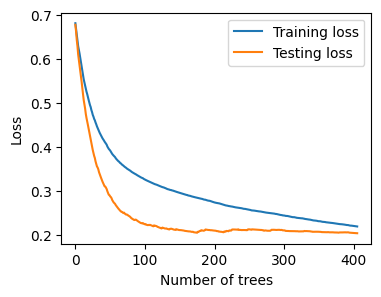

In [36]:
mod_cat = cat.CatBoostClassifier(cat_features=cat_cols, random_seed=77,
                           verbose=200, iterations=cat_it,
                           **cat_params
                          )
mod_cat.fit(x_train, y_train, verbose=0,
            eval_set=[(x_train, y_train), (x_test, y_test)])
results = mod_cat.evals_result_
plt.figure(figsize=(4,3))
plt.plot(results["validation_0"]["Logloss"], label="Training loss")
plt.plot(results["validation_1"]["Logloss"], label="Testing loss")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

In [46]:
result_cat = {'train_pred':mod_cat.predict(x_train), 'train_prob':mod_cat.predict_proba(x_train)[:,1],
  'test_pred':mod_cat.predict(x_test), 'test_prob':mod_cat.predict_proba(x_test)[:,1]}
dc.save_py(result_cat, "output/result_cat_imp")


In [74]:
y_pred = mod_cat.predict_proba(x_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
auc
# np.mean(mod_cat.predict(x_test)==y_test)
cat_feat

{'SITE': 0.9500235782592655,
 'AGE': 2.7329775909348055,
 'PTGENDER': 0.13385309169419768,
 'PTEDUCAT': 0.5780090222651558,
 'PTETHCAT': 0.2847478810642008,
 'PTRACCAT': 0.09959543789228589,
 'PTMARRY': 0.0564805878631779,
 'APOE4': 0.6597465880062384,
 'FDG': 2.3010245414031627,
 'AV45': 1.1199578521875158,
 'CDRSB': 6.400816492989612,
 'ADAS11': 1.8870130318716407,
 'ADAS13': 4.134867928700232,
 'ADASQ4': 0.8665799359009064,
 'MMSE': 0.12435974690785896,
 'RAVLT_immediate': 4.775101259410605,
 'RAVLT_learning': 0.6998447716298516,
 'RAVLT_forgetting': 0.5609237596034138,
 'RAVLT_perc_forgetting': 0.8990686941877835,
 'LDELTOTAL': 4.197380009523188,
 'TRABSCOR': 1.3568626021316346,
 'FAQ': 13.117128914144487,
 'MOCA': 0.6448101320934277,
 'EcogPtMem': 0.7247717297732043,
 'EcogPtLang': 0.5709476971590635,
 'EcogPtVisspat': 0.13379082296490852,
 'EcogPtPlan': 0.4448943973856174,
 'EcogPtOrgan': 0.1374723372748857,
 'EcogPtDivatt': 0.55491847631212,
 'EcogPtTotal': 1.1790064241317557,
 

In [62]:
cat_feat = dict(zip(mod_cat.feature_names_, 
                    mod_cat.get_feature_importance() ))
dc.save_py(cat_feat, "output/cat_feat")


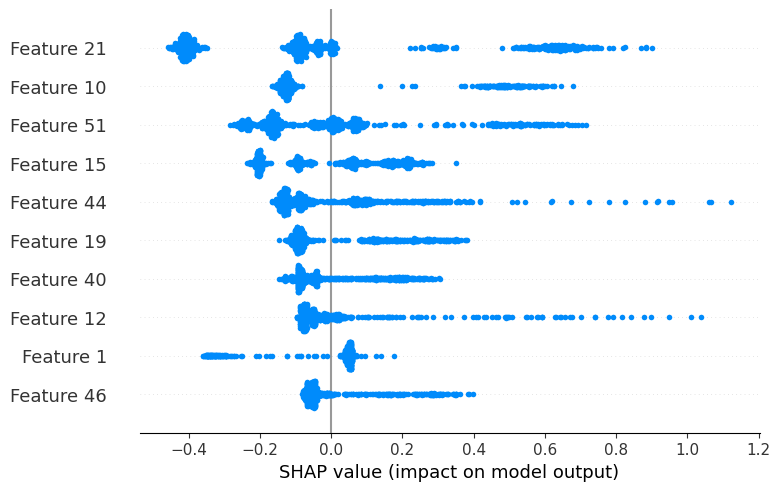

In [66]:
import shap
explainer = shap.TreeExplainer(mod_cat)
shap_values = explainer.shap_values(x_train)
# shap.plots.beeswarm(shap_values)
shap.summary_plot(shap_values, max_display=10, show=False)